In [1]:
%matplotlib nbagg

In [2]:
from transCSSR_bc import *

import graphviz

import matplotlib.pyplot as plt

In [3]:
# Yt is the output. Xt should be set to the null string.

data_prefix = ''

Yt_name = 'even'
# Yt_name = 'golden-mean'

Xt_name = ''

machine_fname = 'transCSSR_results/+.dot'
transducer_fname = 'transCSSR_results/+{}.dot'.format(Yt_name)

In [4]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#
# Load in the data for each process.
#
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

stringY = open('data/{}{}.dat'.format(data_prefix, Yt_name)).readline().strip()

if Xt_name == '':
	stringX = '0'*len(stringY)
else:
	stringX = open('data/{}{}.dat'.format(data_prefix, Xt_name)).readline().strip()

In [5]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#
# Set the parameters and associated quantities:
# 	axs, ays -- the input / output alphabets
# 	alpha    -- the significance level associated with
# 	            CSSR's hypothesis tests.
# 	L        -- The maximum history length to look
#               back when inferring predictive
#               distributions.
#
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

axs = ['0']
ays = ['0', '1']

e_symbols = list(itertools.product(axs, ays)) # All of the possible pairs of emission
                                              # symbols for (x, y)

alpha = 0.001

verbose = False

# L is the maximum amount we want to ever look back.

L_max_words = 10
L_max_CSSR  = 3

inf_alg = 'transCSSR'

Tx = len(stringX); Ty = len(stringY)

assert Tx == Ty, 'The two time series must have the same length.'

T = Tx

In [6]:
word_lookup_marg, word_lookup_fut = estimate_predictive_distributions(stringX, stringY, L_max_words)

epsilon, invepsilon, morph_by_state = run_transCSSR(word_lookup_marg, word_lookup_fut, L_max_CSSR, axs, ays, e_symbols, Xt_name, Yt_name, alpha = alpha)

print 'The epsilon-transducer has {} states.'.format(len(invepsilon))

print_morph_by_states(morph_by_state, axs, ays, e_symbols)

Estimating predictive distributions.
The epsilon-transducer has 2 states.
state = 1, x = 0, P(Yt | Xt, state) = [0.50361797 0.49638203]
state = 3, x = 0, P(Yt | Xt, state) = [0. 1.]


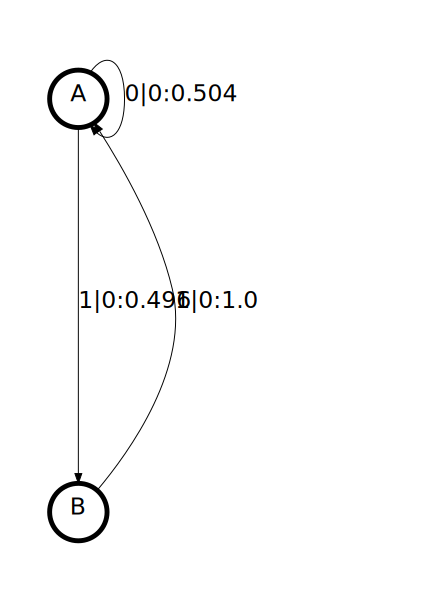

In [7]:
graphviz.Source.from_file(transducer_fname)

In [8]:
pred_probs_by_time, cur_states_by_time = filter_and_pred_probs(stringX, stringY, machine_fname, transducer_fname, axs, ays, inf_alg)

In [9]:
from sklearn.metrics import log_loss

stringY_train = stringY[:len(stringY)//2]
stringY_test  = stringY[len(stringY)//2:]

stringX_train = '0'*len(stringY_train)
stringX_test  = '0'*len(stringY_test)

ays_lookup = {}

for y_ind, y in enumerate(ays):
    ays_lookup[y] = y_ind

arrayY = numpy.zeros(len(stringY_test), dtype = 'int16')

for t, y in enumerate(stringY_test):
    arrayY[t] = ays_lookup[y]

word_lookup_marg, word_lookup_fut = estimate_predictive_distributions(stringX_train, stringY_train, L_max_words)

log_loss_by_L = []

Ls = range(1, L_max_words+1)

for L in Ls:
    epsilon, invepsilon, morph_by_state = run_transCSSR(word_lookup_marg, word_lookup_fut, L, axs, ays, e_symbols, Xt_name, Yt_name, alpha = alpha)
    
    pred_probs_by_time, cur_states_by_time = filter_and_pred_probs(stringX_test, stringY_test, machine_fname, transducer_fname, axs, ays, inf_alg)
    
    log_loss_by_L.append(log_loss(y_pred=pred_probs_by_time, y_true=arrayY[:-1]))
    
    print('Using L = {}, the Log-Loss is {}.'.format(L, log_loss_by_L[-1]))

L_opt = Ls[numpy.nanargmin(log_loss_by_L)]

print('Train / Test split with log-loss chooses L_opt = {}'.format(L_opt))

Estimating predictive distributions.
Using L = 1, the Log-Loss is 0.607364745855.
Using L = 2, the Log-Loss is 0.550187218737.
Using L = 3, the Log-Loss is 0.463082703824.
Using L = 4, the Log-Loss is 0.463081804279.
Using L = 5, the Log-Loss is 0.463081804279.
Using L = 6, the Log-Loss is 0.463081804279.
Using L = 7, the Log-Loss is 0.463081804279.
Using L = 8, the Log-Loss is 0.463081804279.
Using L = 9, the Log-Loss is 0.46308357711.
Using L = 10, the Log-Loss is 0.46308357711.
Train / Test split with log-loss chooses L_opt = 4


<IPython.core.display.Javascript object>


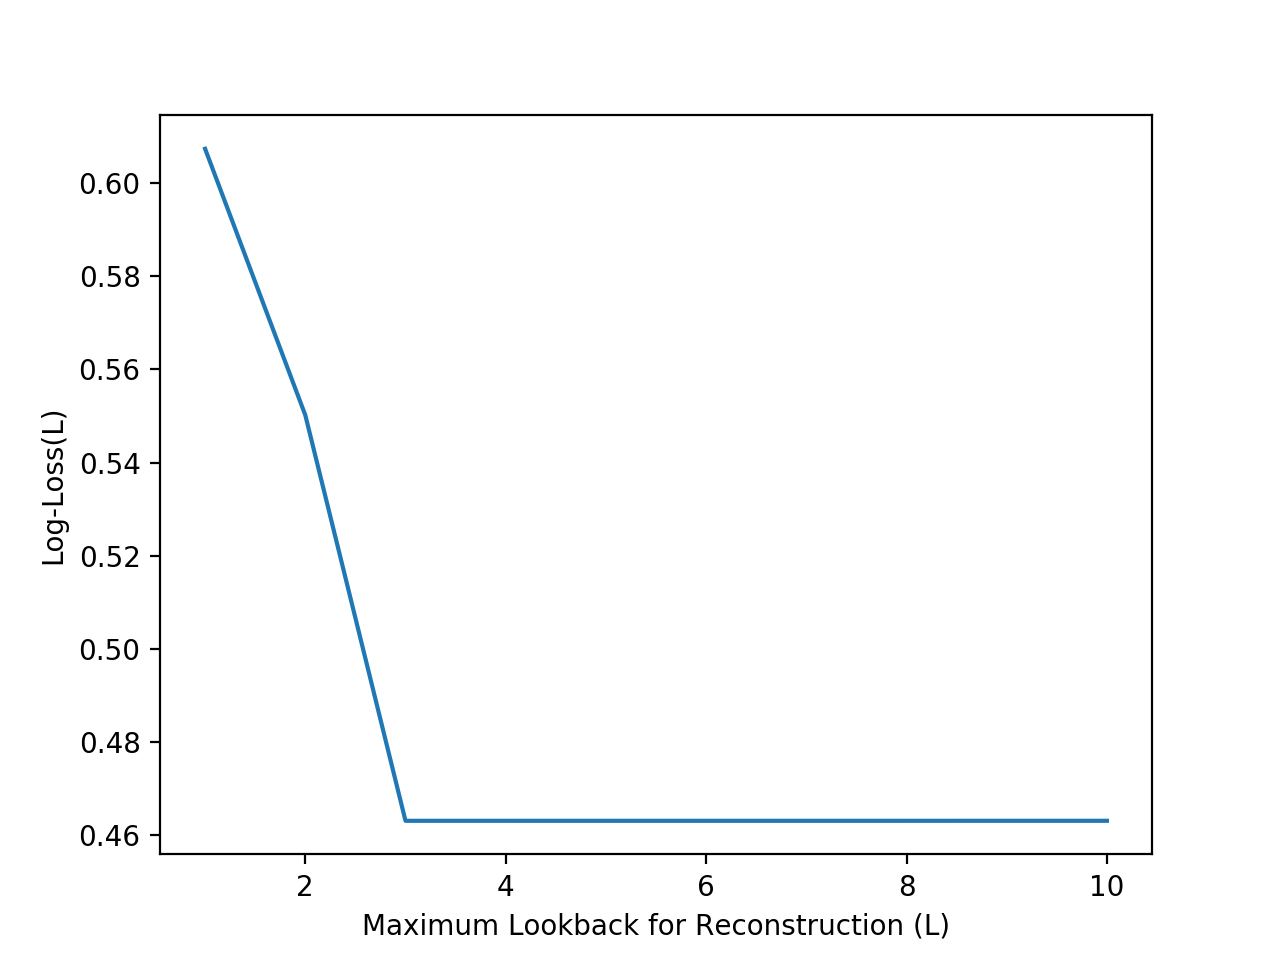

Text(0,0.5,'Log-Loss(L)')

In [13]:
plt.figure()
plt.plot(Ls, log_loss_by_L)
plt.xlabel('Maximum Lookback for Reconstruction (L)')
plt.ylabel('Log-Loss(L)')

In [11]:
word_lookup_marg, word_lookup_fut = estimate_predictive_distributions(stringX, stringY, L_opt)

epsilon, invepsilon, morph_by_state = run_transCSSR(word_lookup_marg, word_lookup_fut, L_opt, axs, ays, e_symbols, Xt_name, Yt_name, alpha = alpha)

Estimating predictive distributions.


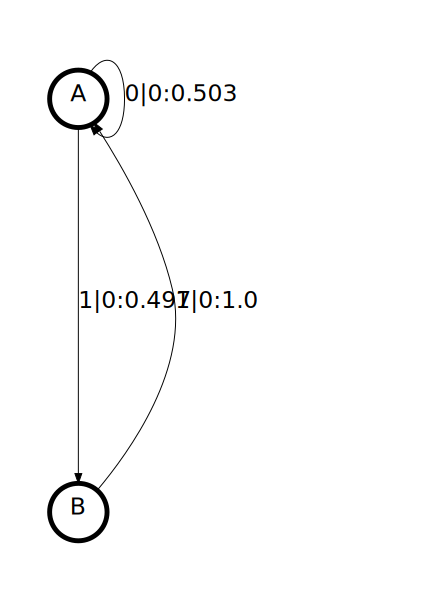

In [12]:
graphviz.Source.from_file(transducer_fname)